In [20]:
import os
import cv2
import json
import numpy as np
import torch.nn as nn
import torch
from torch import optim

In [168]:
def get_dataset_paths(data_path):
    '''
    Get the file paths for the real and synthetic data
    :param data_path: The path to the data
    :return: real_data_files: The file paths for the real data
             synthetic_data_files: The file paths for the synthetic data
    '''
    # Load all the image file paths for real and synthetic data
    synthetic_data = os.path.join(data_path, "ThisPersonDoesNotExist")
    synthetic_data_files = []
    for dir in os.listdir(synthetic_data):
        synthetic_data_files.extend([os.path.join(synthetic_data, dir, f) for f in os.listdir(os.path.join(synthetic_data, dir))])

    # Load the json subset of the real data
    with open("real_faces_subset.json") as f:
        real_data_json = json.load(f)
    
    # Build the real data file paths
    real_data_files = []
    for file_entry in real_data_json['files']:
        real_data_files.append(os.path.join(data_path, file_entry))
    
    return real_data_files, synthetic_data_files


def load_and_resize_images(file_paths, size=(128, 128)):
    '''
    Load the images from the file paths
    :param file_paths: The file paths to the images
    :return: The images in numpy array format
    '''
    images = []
    for file_path in file_paths:
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, size)
        images.append(image)
    return np.array(images)


def shuffle_data(X, y):
    '''
    Shuffles the data
    :param X: The data
    :param y: The labels
    :return: The shuffled data and labels
    '''
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    return X[indices], y[indices]


def split_data(data):
    '''
    Split the data into training, validation and test sets (60 - 20 - 20 split)
    :param data: The data to split
    :return: The training, validation and test sets
    '''
    return np.split(data, [int(0.6 * len(data)), int(0.8 * len(data))])


def augment_data(X_images, augmentations, n_augmentations=5):
    '''
    Augments the data by selecting from a random augmentation from a set of augmentations to apply to a random image
    This is repeated n_augmentations times
    :param X_images: The images in numpy array format
    :param augmentations: The set of augmentations to apply
    :param n_augmentations: The number of augmentations to apply
    :return: X_images: Dataset with augmented images in numpy array format
    '''
    if n_augmentations == 0:
        return X_images

    augmented_images = []
    for i in range(n_augmentations):
        random_index = np.random.randint(0, len(X_images))
        random_augmentation = np.random.choice(augmentations)
        augmented_images.append(random_augmentation(X_images[random_index]))
    
    return np.concatenate((X_images, augmented_images), axis=0)


def add_random_noise(image):
    '''
    Adds random noise to the image
    :param image: The image to add noise to
    :return: The noisy image
    '''
    # Normalize the image to [0, 1]
    normalized_image = image / 255
    # Add Gaussian noise
    noise = np.random.normal(0, 0.05, normalized_image.shape)
    noisy_image = normalized_image + noise
    # Clip the noisy image to [0, 1]
    noisy_image_clipped = np.clip(noisy_image, 0, 1)
    # Convert the noisy image back to [0, 255]
    return (noisy_image_clipped * 255).astype(np.uint8)


def jitter_image(image):
    '''
    Randomly shifts the image either up, down, left or right by a random small amount of pixels
    :param image: The image to jitter
    :return: The jittered image
    '''
    # Choose a random direction to shift the image
    direction = np.random.choice(["up", "down", "left", "right"])
    # Choose a random amount to shift the image
    amount = np.random.randint(1, 10)
    # Sample a random pixel on the direction edge for the color to use
    # This does not look as good as it sounds
    if direction == "up":
        color = image[0, np.random.randint(0, image.shape[1])]
    elif direction == "down":
        color = image[-1, np.random.randint(0, image.shape[1])]
    elif direction == "left":
        color = image[np.random.randint(0, image.shape[0]), 0]
    else:
        color = image[np.random.randint(0, image.shape[0]), -1]

    # Shift the image and replace the empty space with border color pixels
    if direction == "up":
        jittered_image = np.vstack((np.full((amount, image.shape[1], 3), color), image[:-amount]))
    elif direction == "down":
        jittered_image = np.vstack((image[amount:], np.full((amount, image.shape[1], 3), color)))
    elif direction == "left":
        jittered_image = np.hstack((np.full((image.shape[0], amount, 3), color), image[:, :-amount]))
    else:
        jittered_image = np.hstack((image[:, amount:], np.full((image.shape[0], amount, 3), color)))
    return jittered_image

In [169]:
real_files, synthetic_files = get_dataset_paths("dataset")
real_images = load_and_resize_images(real_files)
synthetic_images = load_and_resize_images(synthetic_files)

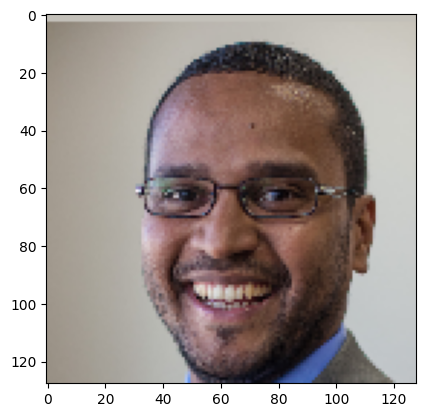

In [170]:
from matplotlib import pyplot as plt
img = real_images[0]
augmentations = [   lambda image: cv2.flip(image, 1),
                    lambda image: add_random_noise(image),
                    lambda image: jitter_image(image)]
img = augmentations[2](img)
plt.imshow(img)
# Not using jitter for now
augmentations = [lambda image: cv2.flip(image, 1),
                 lambda image: add_random_noise(image)]

In [171]:
target_dataset_size = 10000
real_images = augment_data(real_images, augmentations, target_dataset_size - len(real_images))
synthetic_images = augment_data(synthetic_images, augmentations, target_dataset_size - len(synthetic_images))
print(len(real_images))
print(len(synthetic_images))

10000
10000


In [172]:
# Combined Data with associated labels
X = np.concatenate((real_images, synthetic_images))
y = np.concatenate((np.ones(len(real_images)), np.zeros(len(synthetic_images))))

In [173]:
X, y = shuffle_data(X, y)

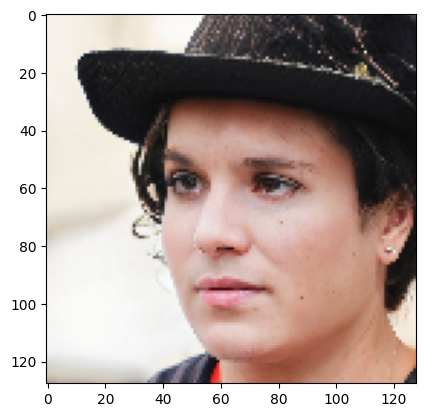

In [174]:
img = X[0]
plt.imshow(img)

In [175]:
print(img.shape)

(128, 128, 3)


In [176]:
X_train, X_val, X_test = split_data(X)
y_train, y_val, y_test = split_data(y)

In [ ]:
# Final

Epoch [1/50], Train Loss: 0.6845, Val Loss: 0.6413
Epoch [2/50], Train Loss: 0.6560, Val Loss: 0.6400
Epoch [3/50], Train Loss: 0.6351, Val Loss: 0.6287
Epoch [4/50], Train Loss: 0.6201, Val Loss: 0.6028
Epoch [5/50], Train Loss: 0.6057, Val Loss: 0.5666
Epoch [6/50], Train Loss: 0.5992, Val Loss: 0.7363
Epoch [7/50], Train Loss: 0.5964, Val Loss: 0.5805
Epoch [8/50], Train Loss: 0.5799, Val Loss: 0.5398
Epoch [9/50], Train Loss: 0.5681, Val Loss: 0.5498
Epoch [10/50], Train Loss: 0.5593, Val Loss: 0.5292
Epoch [11/50], Train Loss: 0.5583, Val Loss: 0.5361
Epoch [12/50], Train Loss: 0.5436, Val Loss: 0.5165
Epoch [13/50], Train Loss: 0.5401, Val Loss: 0.5036
Epoch [14/50], Train Loss: 0.5402, Val Loss: 0.5512
Epoch [15/50], Train Loss: 0.5264, Val Loss: 0.4960
Epoch [16/50], Train Loss: 0.5194, Val Loss: 0.5093
Epoch [17/50], Train Loss: 0.5073, Val Loss: 0.5233
Epoch [18/50], Train Loss: 0.5124, Val Loss: 0.4732
Epoch [19/50], Train Loss: 0.4990, Val Loss: 0.4708
Epoch [20/50], Train 

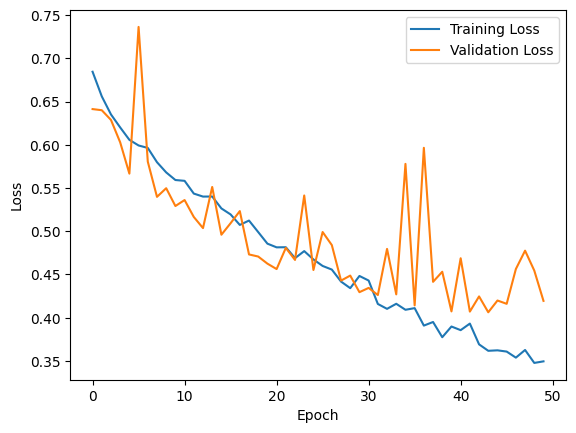

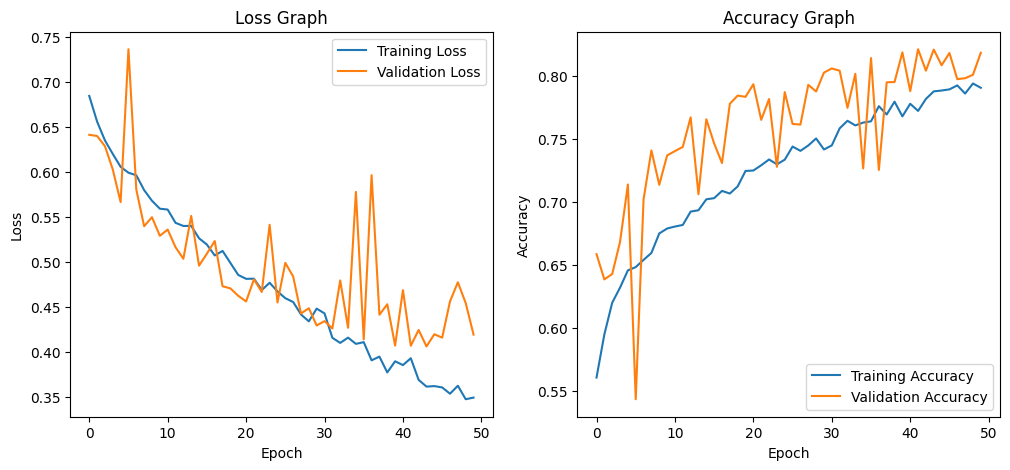

In [177]:
import matplotlib.pyplot as plt

class FCLayer(nn.Module):
    def __init__(self, input_size):
        super(FCLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.01),

            nn.Linear(512, 128),
            nn.LeakyReLU(0.01),

            nn.Linear(128, 1),
            nn.Dropout(0.3),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        output = self.model(x)
        return output
    
def calculate_accuracy(y_pred, y_true):
    predicted = y_pred.round()  
    correct = (predicted == y_true).float() 
    accuracy = correct.sum() / len(correct) 
    return accuracy

def fc_classification(X_train, y_train, X_val,y_val, X_test, y_test, batch_size, n_epochs, learning_rate):
    X_train = X_train / 255.0
    X_val = X_val / 255.0

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    input_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]  
    model = FCLayer(input_size=input_size)
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        train_accuracy = 0
        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_function(outputs, labels.view(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            acc = calculate_accuracy(outputs, labels.view(-1, 1))
            train_accuracy += acc.item() * images.size(0)
        train_losses.append(train_loss / len(train_loader.dataset))
        train_accuracy /= len(train_loader.dataset)
        train_accuracies.append(train_accuracy)
        
        
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = loss_function(outputs, labels.view(-1, 1))
                val_loss += loss.item() * images.size(0)
                acc = calculate_accuracy(outputs, labels.view(-1, 1))
                val_accuracy += acc.item() * images.size(0)
                
        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracy /= len(val_loader.dataset)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Graph')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Graph')
    plt.legend()

    plt.show()

    return model

model = fc_classification(X_train, y_train, X_val,y_val, X_test, y_test, batch_size=32, n_epochs=50, learning_rate=0.0001)


In [226]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score , confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader: 
        outputs = model(images)
        predicted = outputs.round().view(-1).cpu().numpy()  
        labels = labels.view(-1).cpu().numpy() 

        # 예측값과 실제 레이블을 리스트에 추가
        all_predictions.extend(predicted)
        all_labels.extend(labels)

# Precision, Recall, F1 Score 계산
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
accuracy = accuracy_score(all_labels, all_predictions)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy Score: {accuracy:.4f}')


Precision: 0.8252
Recall: 0.8013
F1 Score: 0.8131
Accuracy Score: 0.8183


In [227]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score , confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader: 
        outputs = model(images)
        predicted = outputs.round().view(-1).cpu().numpy()  
        labels = labels.view(-1).cpu().numpy() 

       
        all_predictions.extend(predicted)
        all_labels.extend(labels)


precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
accuracy = accuracy_score(all_labels, all_predictions)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy Score: {accuracy:.4f}')


Precision: 0.5140
Recall: 1.0000
F1 Score: 0.6790
Accuracy Score: 0.5140


In [221]:
loss_function = nn.BCELoss()
batch_size = 32

X_test = torch.tensor(X_test, dtype=torch.float32)
X_test = X_test / 255.0
y_test = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model.eval()
test_loss = 0
test_accuracy = 0

with torch.no_grad():
    for images, labels in test_loader:
        # print(images.shape)
        outputs = model(images)
        loss = loss_function(outputs, labels.view(-1, 1))
        test_loss += loss.item() * images.size(0)
        acc = calculate_accuracy(outputs, labels.view(-1, 1))
        test_accuracy += acc.item() * images.size(0)
        # print(images.shape)
        
test_loss /= len(test_loader.dataset)
test_accuracy /= len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

/var/folders/q4/cqv7j36s2yb432t_8rxmvvk80000gn/T/ipykernel_7020/1548736737.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
/var/folders/q4/cqv7j36s2yb432t_8rxmvvk80000gn/T/ipykernel_7020/1548736737.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


Test Loss: 0.6932, Test Accuracy: 0.5140


/var/folders/q4/cqv7j36s2yb432t_8rxmvvk80000gn/T/ipykernel_7020/1234351348.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)
/var/folders/q4/cqv7j36s2yb432t_8rxmvvk80000gn/T/ipykernel_7020/1234351348.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(y_val, dtype=torch.float32)
/var/folders/q4/cqv7j36s2yb432t_8rxmvvk80000gn/T/ipykernel_7020/1234351348.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
/var/folders/q

1581 1692 335 392
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.04697263240814209, 1.0, 1.0, 1.0, 2.39549535376716e-27, 0.0, 0.0, 0.0, 6.3237444880763955e-21, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.6831562536244746e-06, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 

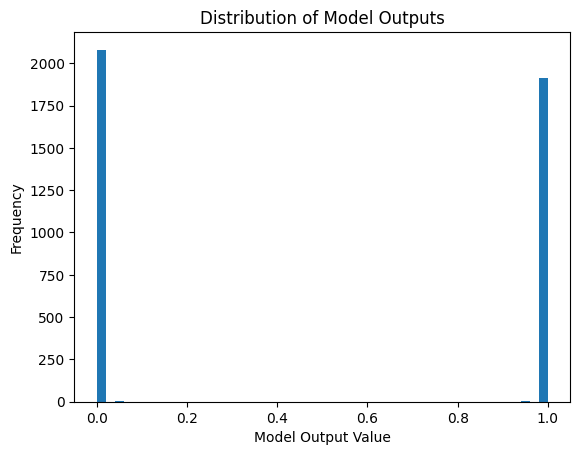

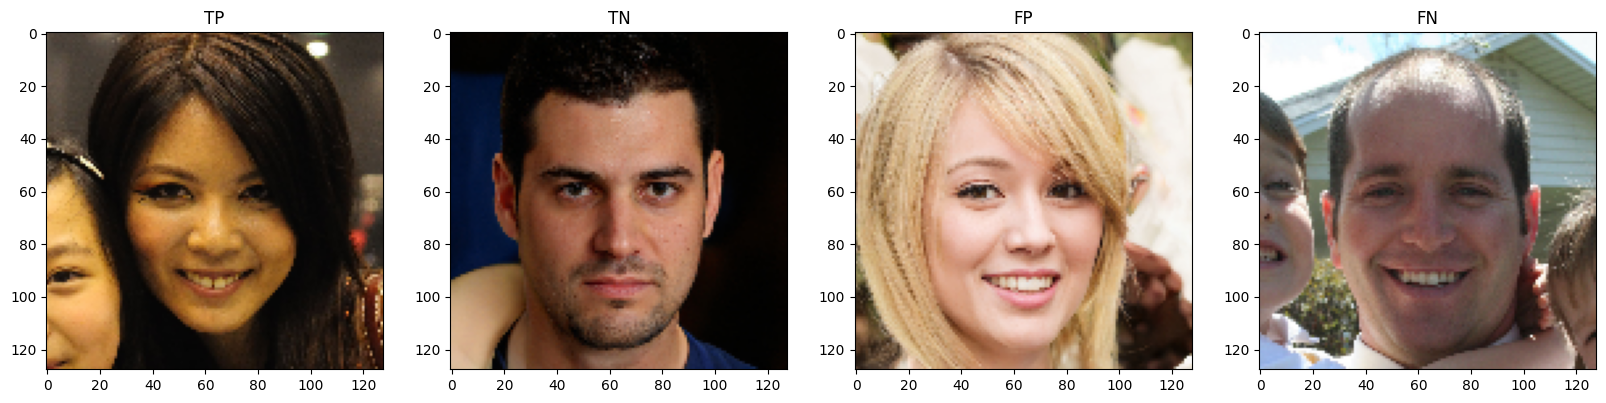

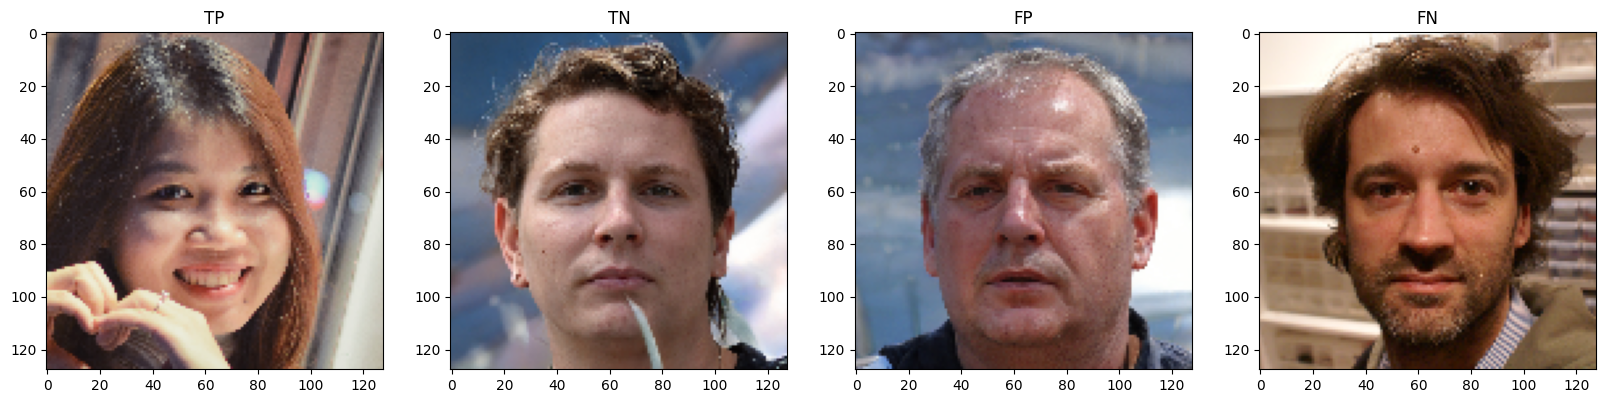

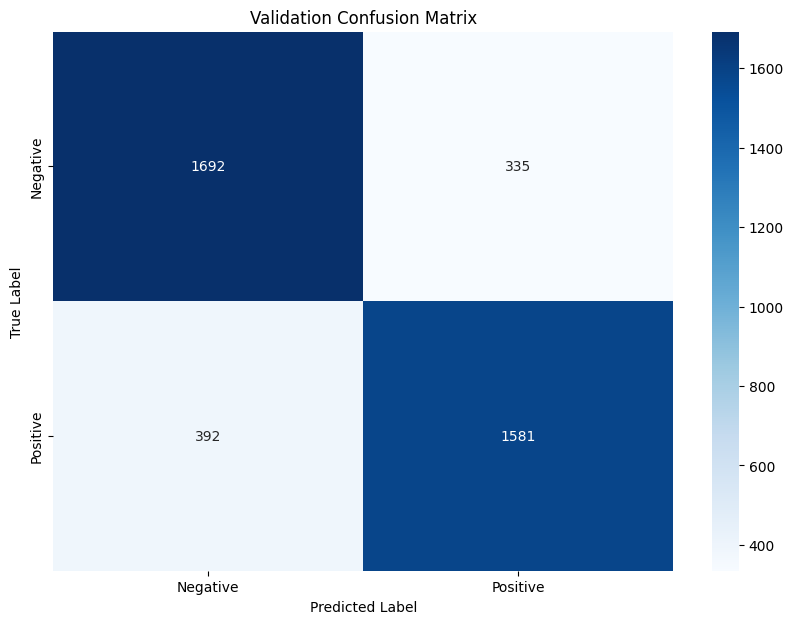

In [228]:

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


X_test = torch.tensor(X_test, dtype=torch.float32)
X_test = X_test/255.0
y_test = torch.tensor(y_test, dtype=torch.float32)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



tp_images, tn_images, fp_images, fn_images = [], [], [], []
check_label = []
all_labels = []
all_predictions = []


model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        # print(images.shape)
        outputs = model(images)
        predictions = outputs.round() 
        check_label.extend(outputs.view(-1).tolist())
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        for idx, (pred, label) in enumerate(zip(predictions, labels.view(-1, 1))):
            if pred == 1 and label == 1:
                tp_images.append(images[idx])
            elif pred == 0 and label == 0:
                tn_images.append(images[idx])
            elif pred == 1 and label == 0:
                fp_images.append(images[idx])
            elif pred == 0 and label == 1:
                fn_images.append(images[idx])
print(len(tp_images), len(tn_images),len(fp_images),len(fn_images))
print(check_label)


plt.hist(check_label, bins=50)
plt.xlabel('Model Output Value')
plt.ylabel('Frequency')
plt.title('Distribution of Model Outputs')
plt.show()

selected_images = [tp_images[0], tn_images[0], fp_images[0], fn_images[0]]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
categories = ['TP', 'TN', 'FP', 'FN']
for i, img in enumerate(selected_images):
    img = img.numpy()  
    img = np.clip(img , 0, 255).astype(np.uint8) 
    
    axes[i].imshow(img)
    axes[i].set_title(categories[i])
plt.show()

selected_images = [tp_images[2], tn_images[2], fp_images[2], fn_images[2]]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
categories = ['TP', 'TN', 'FP', 'FN']
for i, img in enumerate(selected_images):
    img = img.numpy() 
    img = np.clip(img , 0, 255).astype(np.uint8)  
    axes[i].imshow(img)
    axes[i].set_title(categories[i])
plt.show()

all_labels = [label.item() for label in all_labels] 
all_predictions = [pred.item() for pred in all_predictions]

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



/var/folders/q4/cqv7j36s2yb432t_8rxmvvk80000gn/T/ipykernel_7020/3042730712.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)
/var/folders/q4/cqv7j36s2yb432t_8rxmvvk80000gn/T/ipykernel_7020/3042730712.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(y_val, dtype=torch.float32)
/var/folders/q4/cqv7j36s2yb432t_8rxmvvk80000gn/T/ipykernel_7020/3042730712.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
/var/folders/q

2056 0 1944 0


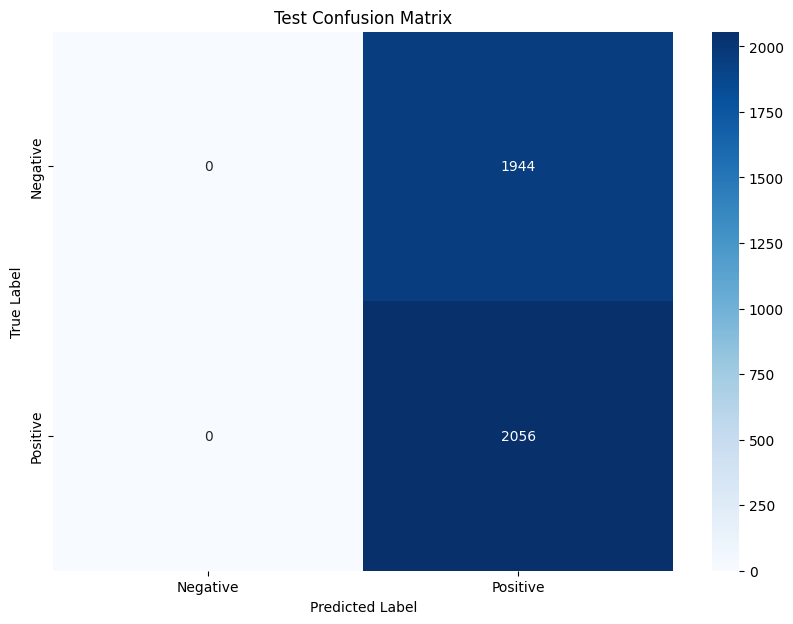

In [232]:

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


X_test = torch.tensor(X_test, dtype=torch.float32)
X_test = X_test/255.0
y_test = torch.tensor(y_test, dtype=torch.float32)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



tp_images, tn_images, fp_images, fn_images = [], [], [], []
check_label = []
all_labels = []
all_predictions = []


model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        # print(images.shape)
        outputs = model(images)
        predictions = outputs.round() 
        check_label.extend(outputs.view(-1).tolist())
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        for idx, (pred, label) in enumerate(zip(predictions, labels.view(-1, 1))):
            if pred == 1 and label == 1:
                tp_images.append(images[idx])
            elif pred == 0 and label == 0:
                tn_images.append(images[idx])
            elif pred == 1 and label == 0:
                fp_images.append(images[idx])
            elif pred == 0 and label == 1:
                fn_images.append(images[idx])
print(len(tp_images), len(tn_images),len(fp_images),len(fn_images))


all_labels = [label.item() for label in all_labels] 
all_predictions = [pred.item() for pred in all_predictions]

cm = confusion_matrix(all_labels, all_predictions)


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

